In [1]:
import sys

sys.path.append('..')

In [2]:
import os
import shap
import glob
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
all_evaluation=glob.glob('../results/**/evaluation.csv', recursive=True)

In [4]:
evaluation_dicts={
    tuple(file.split(os.path.sep)[-4:-1]):pd.read_csv(file).T.rename(columns={
        0: 'RMSE',
        1: 'MBE',
        2: 'R2',
    }) 
    for file in all_evaluation
}

In [5]:
combined_evals=(
    pd.concat(list(evaluation_dicts.values()))
    .reset_index()
    .set_index(
        pd.MultiIndex.from_tuples(
            [
                (model, 'FullDataset', var)
                if land_cover == 'AllCombined'
                else (model, land_cover, var)
                for (model, land_cover, var) in [j for j in list(evaluation_dicts.keys()) for _ in range(2)]
            ]
        )
    )
)

combined_evals

index      RMSE           MBE  \
NNets      NoVegetation baseline   pytorch_nn_train  0.249751 -4.972275e-04   
                        baseline    pytorch_nn_test  0.249336  2.828872e-04   
                        uavsar     pytorch_nn_train  0.163000 -3.725529e-03   
                        uavsar      pytorch_nn_test  0.164637 -3.464129e-03   
           FullDataset  baseline   pytorch_nn_train  0.261438  5.979715e-04   
                        baseline    pytorch_nn_test  0.261268  1.014311e-03   
                        uavsar     pytorch_nn_train  0.172673  9.571586e-03   
                        uavsar      pytorch_nn_test  0.173783  9.539332e-03   
                        all        pytorch_nn_train  0.160189 -3.927405e-03   
                        all         pytorch_nn_test  0.161744 -4.015645e-03   
           Vegetation   baseline   pytorch_nn_train  0.241790 -2.709280e-03   
                        baseline    pytorch_nn_test  0.242492 -2.547943e-03   
                        uavsar     pytorch_nn_train  0.178262 -9.709465e-03   
                        uavsar      pytorch_nn_test  0.180159 -9.402453e-03   
                        all        pytorch_nn_train  0.158704  6.796447e-03   
                        all         pytorch_nn_test  0.161116  7.100856e-03   
ExtraTrees NoVegetation baseline  extra_trees_train  0.200769 -5.161170e-18   
                        baseline   extra_trees_test  0.236504  8.914749e-05   
                        uavsar    extra_trees_train  0.023650 -2.642513e-20   
                        uavsar     extra_trees_test  0.104040  6.126637e-05   
           FullDataset  baseline  extra_trees_train  0.209912  1.974722e-17   
                        baseline   extra_trees_test  0.248343  2.850803e-04   
                        uavsar    extra_trees_train  0.027951  2.052968e-20   
                        uavsar     extra_trees_test  0.108491  2.161469e-04   
                        all       extra_trees_train  0.016214  4.915296e-21   
                        all        extra_trees_test  0.105218  2.681700e-04   
           Vegetation   baseline  extra_trees_train  0.145477  5.138123e-18   
                        baseline   extra_trees_test  0.220102 -3.940482e-04   
                        uavsar    extra_trees_train  0.000964  0.000000e+00   
                        uavsar     extra_trees_test  0.103928  4.113934e-05   
                        all       extra_trees_train  0.010775  4.555720e-21   
                        all        extra_trees_test  0.111764  8.135164e-04   
XGBoost    NoVegetation baseline      xgboost_train  0.248416  1.171146e-06   
                        baseline       xgboost_test  0.248332  6.817620e-04   
                        uavsar        xgboost_train  0.023924 -6.248400e-08   
                        uavsar         xgboost_test  0.098511 -1.455060e-04   
           FullDataset  baseline      xgboost_train  0.260585  3.143228e-07   
                        baseline       xgboost_test  0.260614  3.922229e-04   
                        uavsar        xgboost_train  0.028260 -5.426917e-08   
                        uavsar         xgboost_test  0.104045 -9.044669e-06   
                        all           xgboost_train  0.017086 -3.032342e-08   
                        all            xgboost_test  0.098777  7.750164e-05   
           Vegetation   baseline      xgboost_train  0.240889  1.641974e-05   
                        baseline       xgboost_test  0.242087  1.478522e-04   
                        uavsar        xgboost_train  0.031731 -4.425364e-08   
                        uavsar         xgboost_test  0.109778 -1.569367e-04   
                        all           xgboost_train  0.012394 -2.072812e-08   
                        all            xgboost_test  0.104642  4.677399e-04   

                                        R2  
NNets      NoVegetation baseline  0.318205  
                        baseline  0.321001  
                        uavsar    0.709

In [6]:
combined_evals=(
    combined_evals
    .reset_index()
    .rename(columns={
        'level_0': 'Model',
        'level_1': 'Data',
        'level_2': 'Features',
    })
)

training_evals=(
    combined_evals[
        combined_evals["index"].str.contains("train", case=False)
    ]
    .drop(columns="index")
)

testing_evals=(
    combined_evals[
        combined_evals["index"].str.contains("test", case=False)
    ]
    .drop(columns="index")
)
testing_evals=testing_evals.replace({
    'Vegetation': 'Vegetated Areas',
    'NoVegetation': 'Open Areas',
    'FullDataset': 'Mixed Areas',
    'NNets': "FNN",
    'ExtraTrees': 'Extra Trees',
    'all': 'InSAR + \n BGE + VH',
    'baseline': 'BGE',
    'uavsar': 'InSAR + BGE'
})

training_evals=training_evals.replace({
    'Vegetation': 'Vegetated Areas',
    'NoVegetation': 'Open Areas',
    'FullDataset': 'Mixed Areas',
    'NNets': "FNN",
    'ExtraTrees': 'Extra Trees',
    'all': 'InSAR + \n BGE + VH',
    'baseline': 'BGE',
    'uavsar': 'InSAR + BGE'
})

testing_evals.round(4).to_csv("../results/testing_evaluation_comparison.csv")
training_evals.round(4).to_csv("../results/training_evaluation_comparison.csv")

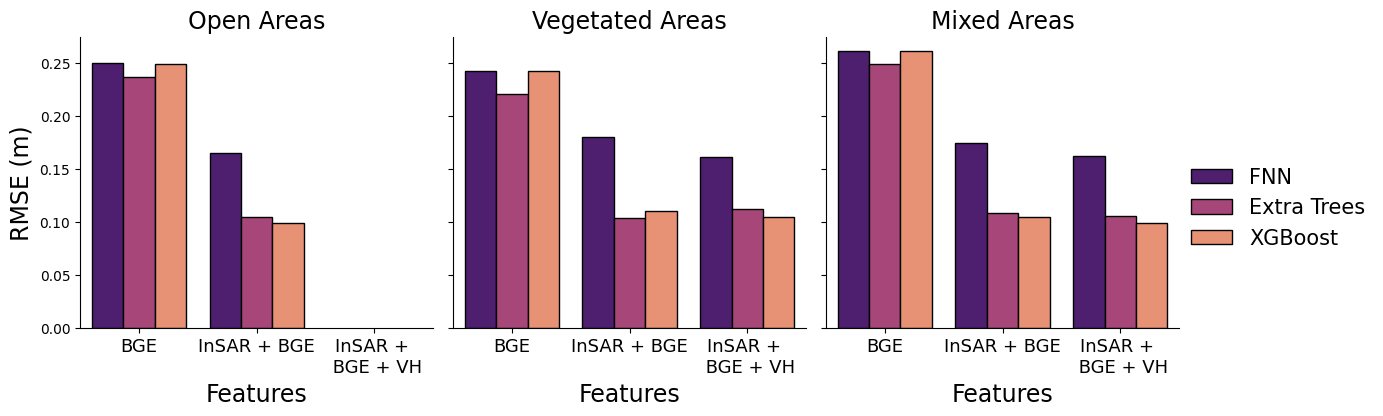

In [7]:
g = sns.FacetGrid(testing_evals, col="Data", height=4, col_order=['Open Areas', 'Vegetated Areas', 'Mixed Areas'])
g.map_dataframe(
    sns.barplot, 
    x="Features", 
    y="RMSE", 
    hue="Model", 
    palette="magma", 
    edgecolor='black', 
   order=['BGE', 'InSAR + BGE', 'InSAR + \n BGE + VH']
)
g.set_axis_labels("Features", "RMSE (m)", fontsize=17)
g.add_legend(fontsize=15)
g.set_xticklabels(rotation=0, fontsize=13)
g.set_titles(template= "{col_name}" ,size=17)

# plt.savefig('../plots/rmse_comparison.png', dpi=300)
plt.show()

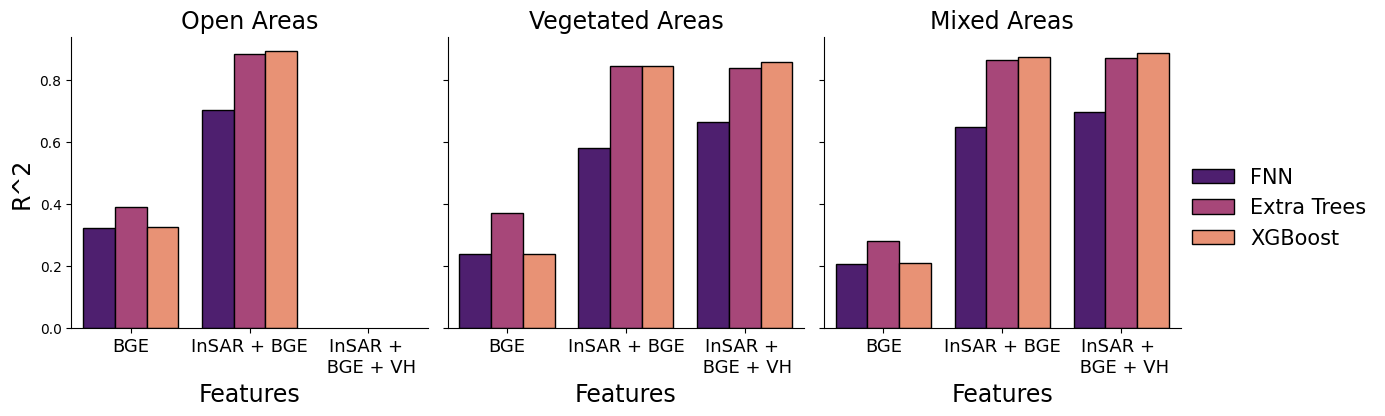

In [8]:
g = sns.FacetGrid(testing_evals, col="Data", height=4, col_order=['Open Areas', 'Vegetated Areas', 'Mixed Areas'])
g.map_dataframe(
    sns.barplot, 
    x="Features", 
    y="R2", 
    hue="Model", 
    palette="magma", 
    edgecolor='black', 
    order=['BGE', 'InSAR + BGE', 'InSAR + \n BGE + VH']
)
g.set_axis_labels("Features", "R^2", fontsize=17)
g.add_legend(fontsize=15)
g.set_xticklabels(rotation=0, fontsize=13)
g.set_titles(template= "{col_name}" ,size=17)

# plt.savefig('../plots/r2_comparison.png', dpi=300)
plt.show()

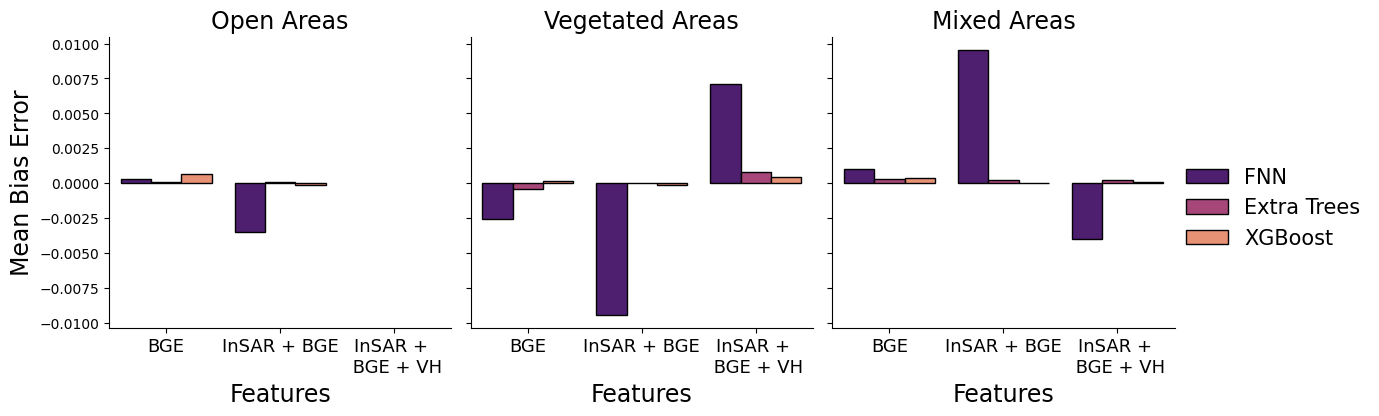

In [10]:
g = sns.FacetGrid(testing_evals, col="Data", height=4, col_order=['Open Areas', 'Vegetated Areas', 'Mixed Areas'])
g.map_dataframe(
    sns.barplot, 
    x="Features", 
    y="MBE", 
    hue="Model", 
    palette="magma", 
    edgecolor='black', 
    order=['BGE', 'InSAR + BGE', 'InSAR + \n BGE + VH']
)
g.set_axis_labels("Features", "Mean Bias Error", fontsize=17)
g.add_legend(fontsize=15)
g.set_xticklabels(rotation=0, fontsize=13)
g.set_titles(template= "{col_name}" ,size=17)

# plt.savefig('../plots/mbe_comparison.png', dpi=300)
plt.show()

## Feature Importance

* Impurity-based Importance

In [30]:
xgboost_all_imp=(
    pd.read_csv('../results/XGBoost/AllCombined/all/feature_importances.csv')
    .assign(feature = lambda x: x['feature'].str.replace('_', ' ').str.title())
    .replace({
        'Vegetation Ht': 'Vegetation Height',
        "Elevation": "Bare Ground Elevation",
    })
    .sort_values('importance', ascending=False)
)

xgboost_all_imp

,feature,importance
0,Unwrapped Phase,0.071002
1,Bare Ground Elevation,0.058629
2,Amplitude,0.031738
3,Incidence Angle,0.027456
4,Vegetation Height,0.020036
5,Coherence,0.012657
6,Wrapped Phase,0.011849


* Shap Importance

In [31]:
with open('../results/shap_values.pkl', 'rb') as f:
    overall_shap = pickle.load(f)

with open('../data/full_splits.pkl', 'rb') as f:
    full_splits = pickle.load(f)

features=[
    'Amplitude','Unwrapped Phase',
    'Coherence', 'Incidence Angle',
    'Bare Ground Elevation', 'Wrapped Phase', 'Vegetation Height'
]

shap_imp=pd.DataFrame(
    data={
        'feature': features,
        'importance': np.abs(overall_shap.values).mean(axis=0)
    }
)

shap_imp=shap_imp.sort_values(by='importance', ascending=False)
shap_imp

,feature,importance
1,Unwrapped Phase,0.084743
4,Bare Ground Elevation,0.082283
0,Amplitude,0.056945
3,Incidence Angle,0.054912
6,Vegetation Height,0.034987
5,Wrapped Phase,0.025693
2,Coherence,0.017929


* Comparison plot

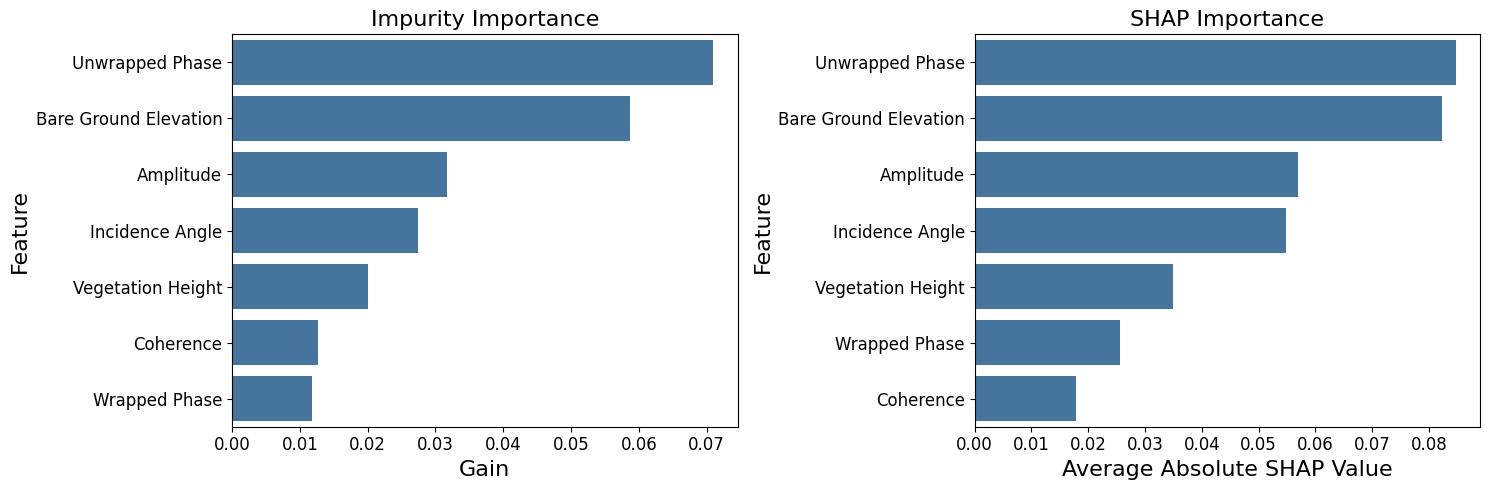

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set_title("Impurity Importance", fontsize=16)
sns.barplot(x="importance", y="feature", data=xgboost_all_imp, ax=ax[0], color='#3776ab')
ax[0].set_xlabel("Gain", fontsize=16)
ax[0].set_ylabel("Feature", fontsize=16)
ax[0].tick_params(labelsize=12)

ax[1].set_title("SHAP Importance", fontsize=16)
sns.barplot(x="importance", y="feature", data=shap_imp, ax=ax[1], color='#3776ab')
ax[1].set_xlabel("Average Absolute SHAP Value", fontsize=16)
ax[1].set_ylabel("Feature", fontsize=16)
ax[1].tick_params(labelsize=12)

plt.tight_layout()

plt.savefig('../plots/feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()